In [1]:
from itertools import combinations
import math
import os

from itertools import combinations
import lightgbm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor

from rs_hdmr_gpr import *

In [2]:
# Extracts the data set
columns = [f'a{i + 1}' for i in range(7)]
columns.append('out')
data = pd.read_csv('KEDdataset.dat', sep='\s+', names=columns)

In [50]:
# Scales the data set to be between [0, 1]
scale = data['out'].max() - data['out'].min()
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data), columns=columns)

In [51]:
features = data_scaled.drop(columns=['out'])
labels = data_scaled['out']

In [52]:
data.head()

,a1,a2,a3,a4,a5,a6,a7,out
0,0.000224,0.000000,0.004583,0.000000,0.000000,0.093880,0.011589,0.002946
1,0.000278,0.000403,0.005023,0.000585,0.007290,0.090925,0.012134,0.003776
2,0.000487,0.001494,0.006073,0.004582,0.018629,0.075739,0.013103,0.006063
3,0.001004,0.002777,0.006860,0.007680,0.018973,0.046869,0.012994,0.008953
4,0.002046,0.003409,0.006222,0.005680,0.010368,0.018924,0.008730,0.010948


In [53]:
data.shape

(585890, 8)

##### Helper Functions

In [58]:
# # Used to predict in batches because the size of the dataset is too large to predict all at once.
def batch_predict(model, data, batch_size=2000, report_size=50000):
    y_predf = []
    i = 0
    while i < data.shape[0]:
        y_pred = model.predict(data.iloc[i: i + batch_size])
        y_predf.extend(y_pred)
        i += batch_size
        if i % report_size == 0:
            print(f'{i} batches have been predicted.')
    return np.array(y_predf)
# Prints the RMSE of the two vectors
def get_RMSE(y, y_pred):
    """Computes the RMSE between two vectors"""
    rmse = math.sqrt(mean_squared_error(y, y_pred))
    print(f'The RMSE is {rmse}')
    return rmse
def plot_for_paper(y, y_pred, xlabel=None, ylabel=None, name=None, save=False, sn=False, ticksize=14):
    """
    Used for correlation plots
    """
    plt.figure()
    if sn:
        plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    if xlabel:
        plt.xlabel(xlabel, size=24)
    if ylabel:
        plt.ylabel(ylabel, size=24)
    plt.scatter(y, y_pred, c='b', s=3)
    plt.grid()
    if save:
        if name is None:
            raise RuntimeError(f'name argument must be provided if save is True.')
        plt.savefig(name, dpi=800, bbox_inches='tight')
    else:
        plt.show()

### Full GPR Fits

In [42]:
# We prepare 3 sets of training and testing data of sizes: 500, 2000 and 5000
x_train1, x_test1, y_train1, y_test1 = train_test_split(data_scaled.drop(columns=['out']), data_scaled['out'], train_size=500, test_size=None, random_state=42)
x_train2, x_test2, y_train2, y_test2 = train_test_split(data_scaled.drop(columns=['out']), data_scaled['out'], train_size=2000, test_size=None, random_state=42)
x_train3, x_test3, y_train3, y_test3 = train_test_split(data_scaled.drop(columns=['out']), data_scaled['out'], train_size=5000, test_size=None, random_state=42)
d = data.shape[1] - 1

In [9]:
# FullGPR initializations. Only isotropic kernels are used.
gpr1 = GaussianProcessRegressor(kernel=RBF(0.5), alpha=5*1e-4, n_restarts_optimizer=1)
gpr2 = GaussianProcessRegressor(kernel=RBF(0.5), alpha=5*1e-4, n_restarts_optimizer=1)
gpr3 = GaussianProcessRegressor(kernel=RBF(0.5), alpha=5*1e-5, n_restarts_optimizer=1)

In [10]:
gpr1.fit(x_train1, y_train1)

GaussianProcessRegressor(alpha=0.0005, copy_X_train=True,
                         kernel=RBF(length_scale=0.5), n_restarts_optimizer=1,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [11]:
gpr2.fit(x_train2, y_train2)

GaussianProcessRegressor(alpha=0.0005, copy_X_train=True,
                         kernel=RBF(length_scale=0.5), n_restarts_optimizer=1,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [12]:
gpr3.fit(x_train3, y_train3)

GaussianProcessRegressor(alpha=5e-05, copy_X_train=True,
                         kernel=RBF(length_scale=0.5), n_restarts_optimizer=1,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [13]:
# Length scale results after fit:
print(gpr1.kernel_, gpr2.kernel_, gpr3.kernel_)

RBF(length_scale=0.686) RBF(length_scale=0.521) RBF(length_scale=0.222)


In [14]:
y_pred1 = batch_predict(gpr1, features)

50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.


In [15]:
y_pred2 = batch_predict(gpr2, features)

50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.


In [16]:
y_pred3 = batch_predict(gpr3, features)

50000 batches have been predicted.
100000 batches have been predicted.
150000 batches have been predicted.
200000 batches have been predicted.
250000 batches have been predicted.
300000 batches have been predicted.
350000 batches have been predicted.
400000 batches have been predicted.
450000 batches have been predicted.
500000 batches have been predicted.
550000 batches have been predicted.


In [17]:
get_RMSE(y_pred1 * scale, labels * scale)
get_RMSE(y_pred2 * scale, labels * scale)
get_RMSE(y_pred3 * scale, labels * scale)

The RMSE is 0.0004314404444684715
The RMSE is 0.00027336156914882503
The RMSE is 0.00016187315695460961


0.00016187315695460961

In [19]:
print('R^2 value for the 500 point fit is:', np.corrcoef(y_pred1 * scale, data_scaled['out'] * scale)[0, 1] ** 2)
print('R^2 value for the 2000 point fit is:', np.corrcoef(y_pred2 * scale, data_scaled['out'] * scale)[0, 1] ** 2)
print('R^2 value for the 5000 point fit is:', np.corrcoef(y_pred3 * scale, data_scaled['out'] * scale)[0, 1] ** 2)

R^2 value for the 500 point fit is: 0.9949682297491327
R^2 value for the 2000 point fit is: 0.9979808597601283
R^2 value for the 5000 point fit is: 0.9992923162641821


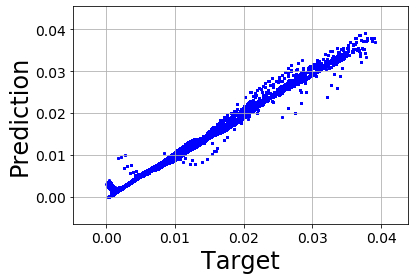

In [20]:
# 500 points
plot_for_paper(data_scaled['out'] * scale, y_pred1 * scale, xlabel='Target', ylabel='Prediction')
# plot_for_paper(data_scaled['out'] * scale, y_pred1 * scale, xlabel='Target', ylabel='Prediction', name=f'fullGPR_500.png', save=True)

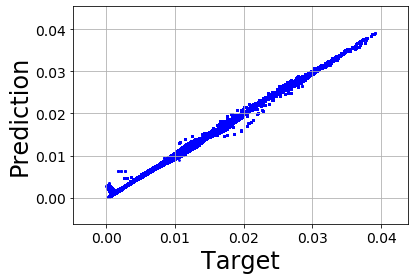

In [21]:
# 2000 points
plot_for_paper(data_scaled['out'] * scale, y_pred2 * scale, xlabel='Target', ylabel='Prediction')
# plot_for_paper(data_scaled['out'] * scale, y_pred2 * scale, xlabel='Target', ylabel='Prediction', name=f'fullGPR_2000.png', save=True)

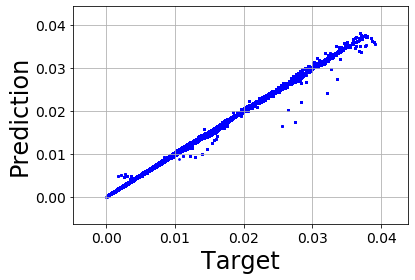

In [22]:
# 5000 points
plot_for_paper(data_scaled['out'] * scale, y_pred3 * scale, xlabel='Target', ylabel='Prediction')
# plot_for_paper(data_scaled['out'] * scale, y_pred3 * scale, xlabel='Target', ylabel='Prediction', name=f'fullGPR_5000.png', save=True)

### HDMR FITS

In [63]:
# Initializes the Model classes for training
matrices1, kernels1 = kernel_matrices(1, 7, 0.5)#, length_scale_bounds=(0.3, 10000))
matrices2, kernels2 = kernel_matrices(2, 7, 0.5)#, length_scale_bounds=(0.3, 10000))
matrices3, kernels3 = kernel_matrices(3, 7, 0.5)#, length_scale_bounds=(0.3, 10000))
matrices4, kernels4 = kernel_matrices(4, 7, 0.5)#, length_scale_bounds=(0.3, 10000))
matrices5, kernels5 = kernel_matrices(5, 7, 0.5)#, length_scale_bounds=(0.3, 10000))
matrices6, kernels6 = kernel_matrices(6, 7, 0.5)#, length_scale_bounds=(0.3, 10000))
matrices7, kernels7 = kernel_matrices(7, 7, 0.5)#, length_scale_bounds=(0.3, 10000))
hdmr_1d = RSHDMRGPR(len(matrices1), matrices1, kernels1)
hdmr_2d = RSHDMRGPR(len(matrices2), matrices2, kernels2)
hdmr_3d = RSHDMRGPR(len(matrices3), matrices3, kernels3)
hdmr_4d = RSHDMRGPR(len(matrices4), matrices4, kernels4)
hdmr_5d = RSHDMRGPR(len(matrices5), matrices5, kernels5)
hdmr_6d = RSHDMRGPR(len(matrices6), matrices6, kernels6)
hdmr_7d = RSHDMRGPR(len(matrices7), matrices7, kernels7)

In [64]:
# models = [hdmr_1d, hdmr_2d, hdmr_3d, hdmr_4d, hdmr_5d,hdmr_6d, hdmr_7d]
hdmr = [hdmr_1d, hdmr_2d, hdmr_3d, hdmr_4d, hdmr_5d, hdmr_6d, hdmr_7d]
alphas = [3 * 1e-3, 8 * 1e-4, 3 * 1e-4, 8 * 1e-5, 3 * 1e-5, 8 * 1e-6, 3 * 1e-6]

In [65]:
# Trains the hdmr model sequentially for 500 training points.
y = [y_train1]
preds = []  # Stores the list of predictions at each stage. Used to compute the RMSE
RMSEs = []  # List of RMSEs between fitted component functions and the actual labels after completion of each hdmr dimension fit.
for i in range(len(hdmr)):
    hdmr[i].train(x_train1, y[i], alphas=alphas[i], cycles=50, optimizer="fmin_l_bfgs_b", opt_every=5, scale_down=(0.2, 2))
    
    y_pred = batch_predict(hdmr[i], data_scaled.drop(columns=['out']))
    preds.append(y_pred.copy())
    for j in range(i):
        y_pred += preds[j]
    rmse = get_RMSE(y_pred * scale, data_scaled['out'] * scale)
    RMSEs.append(rmse)
    
    y_pred1 = hdmr[i].predict(x_train1)
    y.append(y[i] - y_pred1)
# Alternatively, we can use the function sequential_fitting provided in the code. 

7
[True, True, True, True, True, True, True]
Training iteration for CYCLE 1 has started.
Training component function: 1, Optimizer: fmin_l_bfgs_b, RBF(length_scale=2.22)
Training component function: 2, Optimizer: fmin_l_bfgs_b, RBF(length_scale=3.98)
Training component function: 3, Optimizer: fmin_l_bfgs_b, RBF(length_scale=0.118)
Training component function: 4, Optimizer: fmin_l_bfgs_b, RBF(length_scale=3.03)
Training component function: 5, Optimizer: fmin_l_bfgs_b, RBF(length_scale=0.007)
Training component function: 6, Optimizer: fmin_l_bfgs_b, RBF(length_scale=0.00734)
Training component function: 7, Optimizer: fmin_l_bfgs_b, RBF(length_scale=0.0991)
Training iteration for CYCLE 2 has started.
Training component function: 1, Optimizer: None, RBF(length_scale=2.22)
Training component function: 2, Optimizer: None, RBF(length_scale=3.98)
Training component function: 3, Optimizer: None, RBF(length_scale=0.118)
Training component function: 4, Optimizer: None, RBF(length_scale=3.03)
Trai

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF(length_scale=0.454)
Training component function: 2, Optimizer: fmin_l_bfgs_b, RBF(length_scale=0.323)
Training component function: 3, Optimizer: fmin_l_bfgs_b, RBF(length_scale=0.824)
Training component function: 4, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 5, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 6, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 7, Optimizer: fmin_l_bfgs_b, RBF(length_scale=0.419)
Training iteration for CYCLE 42 has started.
Training component function: 1, Optimizer: None, RBF(length_scale=0.454)
Training component function: 2, Optimizer: None, RBF(length_scale=0.323)
Training component function: 3, Optimizer: None, RBF(length_scale=0.824)
Training component function: 4, Optimizer: None, RBF(length_scale=1e+05)
Training component function: 5, Optimizer: None, RBF(length_scale=1e+05)
Training component function: 6, Optimizer: None, RBF(length_scale=1e+05)
T

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF(length_scale=36.8)
Training component function: 8, Optimizer: fmin_l_bfgs_b, RBF(length_scale=190)
Training component function: 9, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 10, Optimizer: fmin_l_bfgs_b, RBF(length_scale=214)
Training component function: 11, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 12, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 13, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 14, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 15, Optimizer: fmin_l_bfgs_b, RBF(length_scale=0.739)
Training component function: 16, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 17, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 18, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 19, Optimizer: fmin_l_bfgs_b, RBF(length_

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF(length_scale=0.349)
Training component function: 4, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 5, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 6, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 7, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 8, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 9, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 10, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 11, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 12, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 13, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 14, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 15, Optimizer: fmin_l_bfgs_b, RBF(length

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF(length_scale=0.349)
Training component function: 4, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 5, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 6, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 7, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 8, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 9, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 10, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 11, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 12, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 13, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 14, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 15, Optimizer: fmin_l_bfgs_b, RBF(length

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF(length_scale=0.349)
Training component function: 4, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 5, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 6, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 7, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 8, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 9, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 10, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 11, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 12, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 13, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 14, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 15, Optimizer: fmin_l_bfgs_b, RBF(length

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF(length_scale=0.349)
Training component function: 4, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 5, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 6, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 7, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 8, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 9, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 10, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 11, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 12, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 13, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 14, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 15, Optimizer: fmin_l_bfgs_b, RBF(length

C:\Users\owenz\Anaconda3\envs\pureai2\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF(length_scale=0.349)
Training component function: 4, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 5, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 6, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 7, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 8, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 9, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 10, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 11, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 12, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 13, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 14, Optimizer: fmin_l_bfgs_b, RBF(length_scale=1e+05)
Training component function: 15, Optimizer: fmin_l_bfgs_b, RBF(length

In [68]:
# RMSEs of 1d, 2d, ... , 7d fits for 500 points
RMSEs

[0.0010560201016815984,
 0.0007746300270143589,
 0.00036002120395339993,
 0.00036002111741319606,
 0.0004711996433538426,
 0.000471199646399643,
 0.0009068083781135795]

In [72]:
preds[j]

array([-7.18728188e-10, -9.85892257e-10, -1.25692168e-09, ...,
        9.17907528e-10,  9.16770659e-10,  9.13360054e-10])

In [73]:
predictions = []
for i in range(len(preds)):
    pred = preds[0].copy()
    for j in range(1, i):
        pred += preds[j]
    predictions.append(pred.copy())

In [74]:
i = 1
for p in predictions:
    v = np.corrcoef(p * scale, data_scaled['out'] * scale)[0,1]
    print(f'R^2 for the {i}d-hdmr fit is', v ** 2)
    i += 1

R^2 for the 1d-hdmr fit is 0.9698845433916666
R^2 for the 2d-hdmr fit is 0.9698845433916666
R^2 for the 3d-hdmr fit is 0.9839424533249236
R^2 for the 4d-hdmr fit is 0.9965035693073234
R^2 for the 5d-hdmr fit is 0.9965035708645962
R^2 for the 6d-hdmr fit is 0.9940067305380239
R^2 for the 7d-hdmr fit is 0.9940067304817507


Correlation plot for 0d-hdmr sequential predictions.


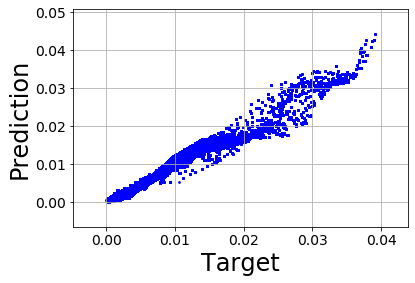

Correlation plot for 1d-hdmr sequential predictions.


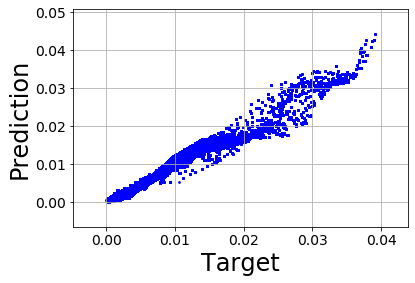

Correlation plot for 2d-hdmr sequential predictions.


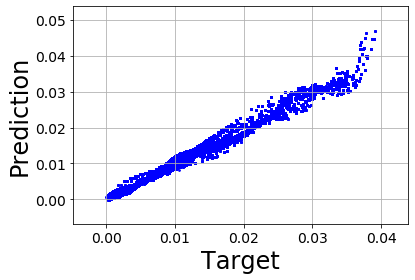

Correlation plot for 3d-hdmr sequential predictions.


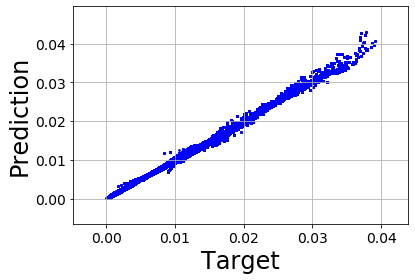

Correlation plot for 4d-hdmr sequential predictions.


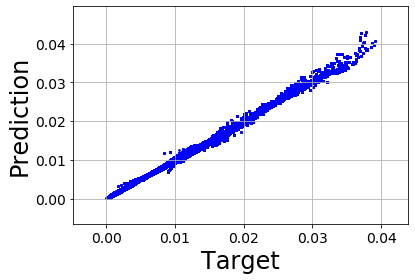

Correlation plot for 5d-hdmr sequential predictions.


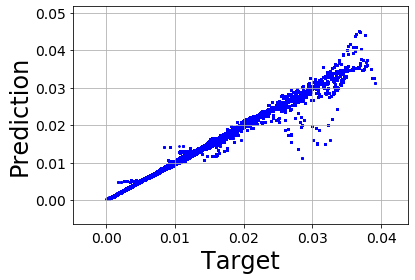

Correlation plot for 6d-hdmr sequential predictions.


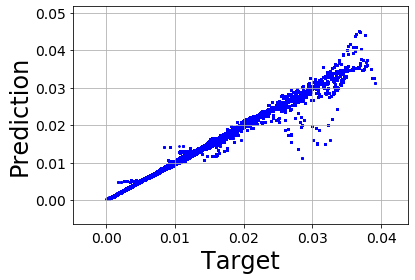

In [76]:
i = 0
for p in predictions:
    print(f'Correlation plot for {i}d-hdmr sequential predictions.')
    plot_for_paper(data_scaled['out'] * scale, p * scale, xlabel='Target', ylabel='Prediction')
    i += 1

In [77]:
# For 2000 and 5000 point sequential fits, please see job2.py and job3.py. As the time/memory usage is too intensive for a normal desktop computer to run, 
# we have created scripts to run on compute canada. The code are in these files respectively.